<a href="https://colab.research.google.com/github/tinumide/cuda-python-examples/blob/main/recursive_subdivision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recursive Subdivision
This example demonstrates a method called recursive subdivision. The algorithm generates a new set of points by recursively dividing a given set of initial points. The recursion is achieved by iteratively increasing the number of threads and blocks, effectively shortening the length of the segments being subdivided.



In [ ]:
import numpy as np
import cupy 
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import random
import matplotlib.pyplot as plt

In [ ]:
@cuda.jit
def kernel_recursive_subdivision(w, out_x, out_y):
  # rng_states, 
  t_idx = cuda.grid(1)

  #calculate read indices
  x1, x2 = int(t_idx*w), int(t_idx*w+w)
  #calculate write indices
  x_out = y_out = int((x1 + x2) // 2)

  #calculate and write new points
  out_x[x_out] = (out_x[x1] + out_x[x2])/ 2
  out_y[y_out] = xoroshiro128p_uniform_float32(rng_states, t_idx)

In [ ]:
n = 9
w = n-1
out_x = np.zeros(n).astype(np.float32)
out_y = np.zeros(n).astype(np.float32)
out_x[0] = 0.0
out_x[w] = 1.0
out_y[0] = 1.0
out_y[w] = 0.7

d_out_x = cuda.to_device(out_x)
d_out_y = cuda.to_device(out_y)

no_threads = 1
max_threads_per_block = 1024
no_blocks = 1
N = w//2


while no_threads <= N:

  if no_threads/no_blocks > max_threads_per_block:
    no_blocks += 1

  threads_per_block = int(no_threads/no_blocks)
  rng_states = create_xoroshiro128p_states(threads_per_block * no_blocks, seed=1)

  kernel_recursive_subdivision[no_blocks, threads_per_block](w, d_out_x, d_out_y)

  cuda.synchronize
  no_threads *= 2
  w /= 2

result_x = d_out_x.copy_to_host()
result_y = d_out_y.copy_to_host() 




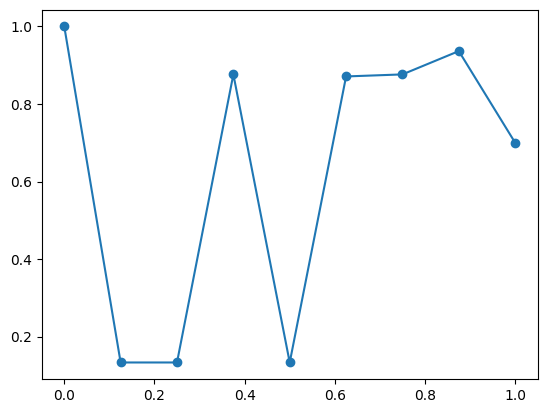

In [ ]:
plt.plot(result_x, result_y, linestyle="-", marker="o")